In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%load_ext autoreload
%autoreload 2

## Player Analysis

In [2]:
player_df = pd.read_csv("csv/common_player_info.csv")
player_df["birthdate"] = pd.to_datetime(player_df["birthdate"])
player_df.rename(columns={"display_first_last": "player_name"}, inplace=True)

### Origin
Country, school or the state (if the player is a US citizen)

In [3]:
def make_hist(df, col, title):
    plt.hist(df[col])
    plt.title(title)

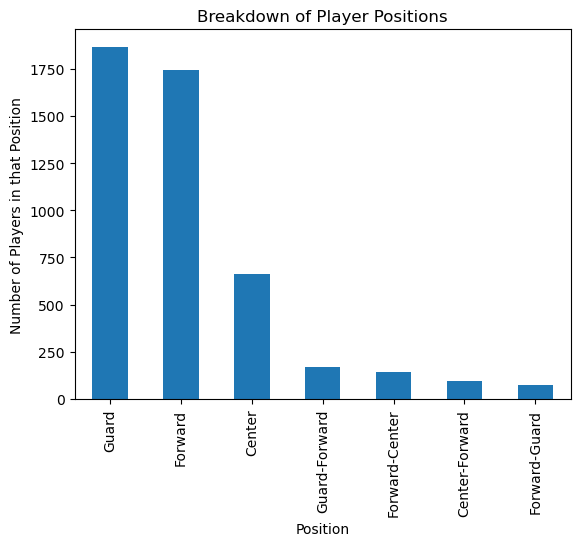

In [4]:
player_df['position'].value_counts().plot(kind='bar')
plt.xlabel("Position")
plt.ylabel("Number of Players in that Position")
plt.title("Breakdown of Player Positions")
plt.show()

In [5]:
def convert_height_to_cm(height):
    if type(height) == float:
        return 0
    feet, inches = height.split('-')
    inches = int(inches)
    inches += int(feet) * 12
    h_cm = round(inches * 2.54, 1)
    return h_cm

In [6]:
# convert height to cm for players with non-null height
player_df['height_cm'] = player_df['height'].apply(convert_height_to_cm)

# impute mean height for players with 0 height_cm
player_df['height_cm'] = player_df['height_cm'].replace(0, player_df['height_cm'].mean())

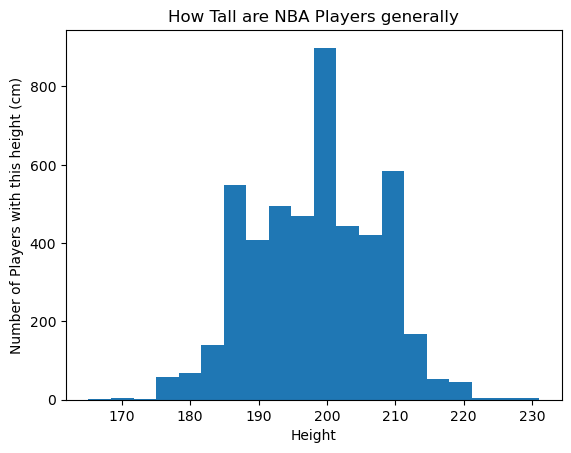

In [7]:
player_df['height_cm'].plot.hist(bins=20)
plt.xlabel("Height")
plt.ylabel("Number of Players with this height (cm)")
plt.title("How Tall are NBA Players generally")
plt.show()

In [8]:
# convert weight to kg for players with non-null weight
player_df['weight_kg'] = player_df['weight'].apply(lambda x: round(x * 0.453592, 1))

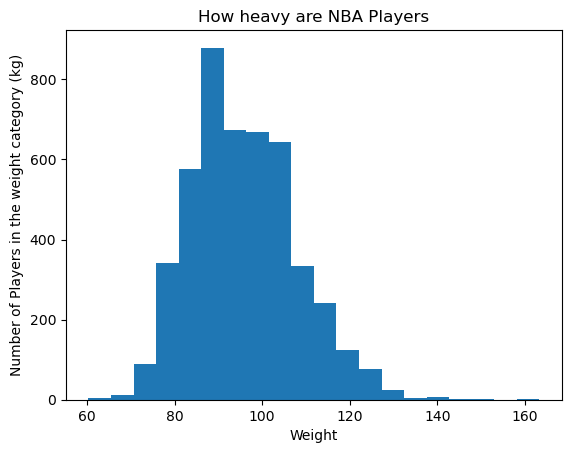

In [9]:
player_df['weight_kg'].plot.hist(bins=20)
plt.xlabel("Weight")
plt.ylabel("Number of Players in the weight category (kg)")
plt.title("How heavy are NBA Players")
plt.show()

### Top 5 Schools producing the most number of NBA Players

In [10]:
player_df['school'].value_counts(ascending=False)[:5]

school
Kentucky          115
UCLA               96
Duke               92
North Carolina     87
Kansas             76
Name: count, dtype: int64

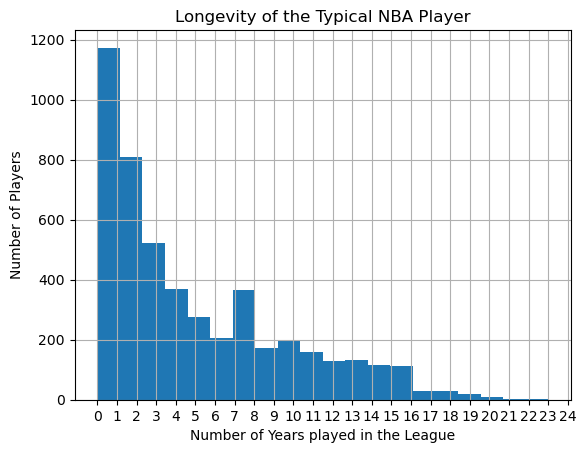

In [11]:
player_df['season_exp'].hist(bins=20)
plt.xticks([i for i in range(25)])
plt.xlabel("Number of Years played in the League")
plt.ylabel("Number of Players")
plt.title("Longevity of the Typical NBA Player")
plt.show()

### Top 5 Countries with the most number of NBA Players

In [12]:
player_df['country'].value_counts(ascending=False)[:5]

country
USA          4361
Canada         48
France         39
Serbia         31
Australia      25
Name: count, dtype: int64

## Draft Related Analyses

### Which Teams Receive the Most Amount of Help from the Draft

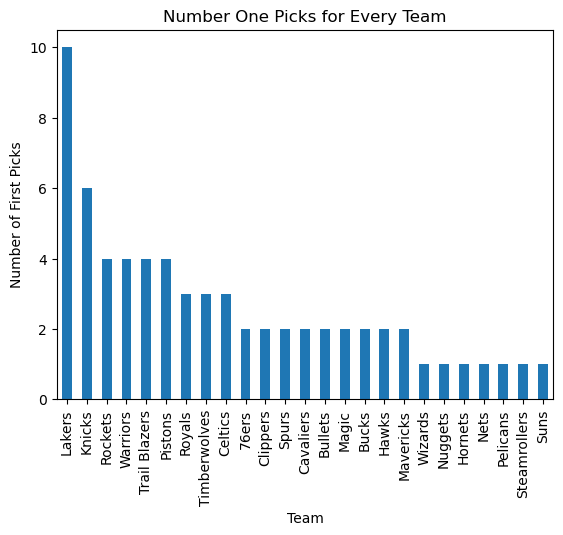

In [13]:
player_df[player_df['draft_number']=="1"]['team_name'].value_counts().plot(kind='bar')
plt.xlabel("Team")
plt.ylabel("Number of First Picks")
plt.title("Number One Picks for Every Team")
plt.show()

# Players & Teams Analysis

In [14]:
import os
import utils

if not os.path.exists("nba-raptor/historical_latest_RAPTOR_by_team.csv"):
    raptor_df = utils.get_and_sort_raptor()
else:
    raptor_df = pd.read_csv("nba-raptor/historical_latest_RAPTOR_by_team.csv")

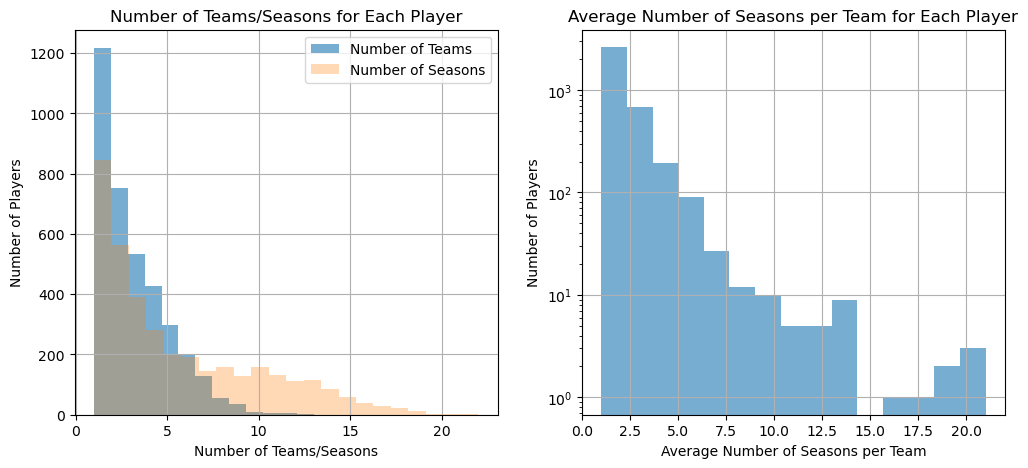

In [15]:
# plot distribution of number of teams in a player's career
team_counts = raptor_df.groupby("player_id")["team"].nunique()
max_team_count = team_counts.max()

season_counts = raptor_df.groupby("player_id")["season"].nunique()
max_season_count = season_counts.max()

def get_team_season_count(player_df):
    team_season_counts = player_df.groupby("team")["season"].nunique()
    return team_season_counts.mean()

team_season_counts = raptor_df.groupby("player_id").apply(get_team_season_count)

# plot both counts on the same plot
fig, axs = plt.subplots(1,2, figsize=(12,5))
team_counts.hist(bins=max_team_count, ax=axs[0], alpha=0.6, label="Number of Teams")
season_counts.hist(bins=max_season_count, ax=axs[0], alpha=0.3, label="Number of Seasons")
team_season_counts.hist(bins=15, ax=axs[1], alpha=0.6, label="Number of Seasons/Team")
axs[0].legend()
axs[0].set_xlabel("Number of Teams/Seasons")
axs[0].set_ylabel("Number of Players")
axs[0].set_title("Number of Teams/Seasons for Each Player")
axs[1].set_yscale("log")
axs[1].set_xlabel("Average Number of Seasons per Team")
axs[1].set_ylabel("Number of Players")
axs[1].set_title("Average Number of Seasons per Team for Each Player")
plt.show()

In [16]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np

def filter_df_season(df, season):
    return df[df["season"] == season]

team_df = pd.read_csv("csv/team.csv")
city_coords = team_df.groupby("location")[["abbreviation", "longitude", "latitude"]].head(100)


def viz_team_counts(season):
    team_counts = filter_df_season(raptor_df, season).groupby("team")["player_id"].count().to_dict()
    plt.figure(figsize=(12,8))
    ax = plt.axes(projection=ccrs.Mercator())

    ax.set_extent([-130, -60, 20, 50])
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES)

    for team, count in team_counts.items():
        city = city_coords[city_coords["abbreviation"] == team]
        try:
            long = city["longitude"].values[0]
            lat = city["latitude"].values[0]
            x, y = np.meshgrid(long, lat)
            ax.plot(x, y, 'ro', markersize=0.5*count, alpha=0.8, transform=ccrs.PlateCarree())
        except IndexError:
            # BRK and PHO not in team.csv (I added them manually by copying from BKN and PHX)
            # also some other team abbreviations that are missing from team.csv
            print(f"Could not find {team} in city_coords")
    plt.show()


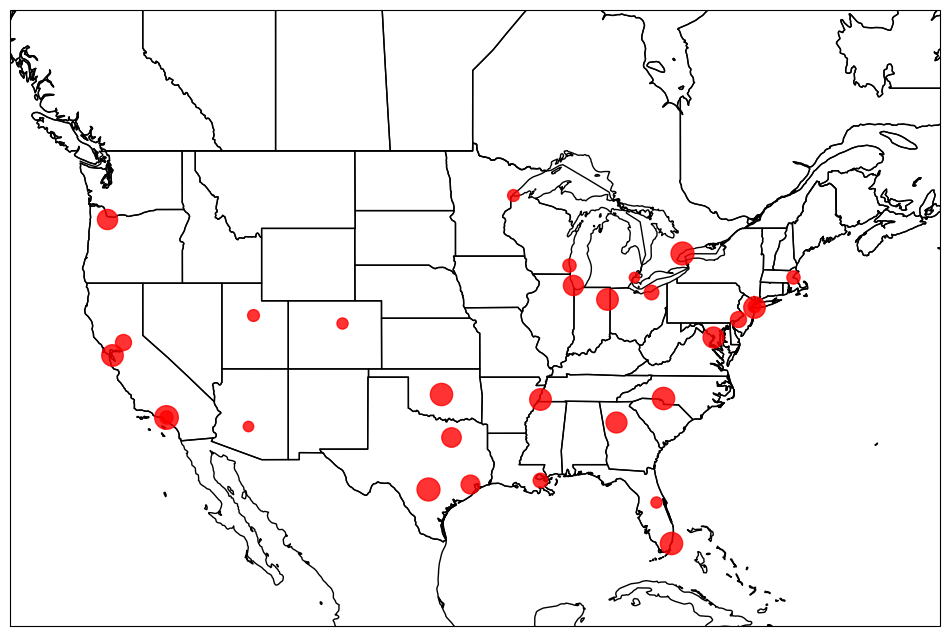

In [17]:
viz_team_counts(2014)

In [18]:
common_names = set(player_df["player_name"]).intersection(set(raptor_df["player_name"]))
print(f"Number of players in both datasets: {len(common_names)}")
common_player_df = player_df[player_df["player_name"].isin(common_names)]
common_raptor_df = raptor_df[raptor_df["player_name"].isin(common_names)]

Number of players in both datasets: 3547


In [19]:
# find players with duplicate names in common_player_df
dupes = common_player_df[common_player_df["player_name"].duplicated(keep=False)].sort_values("player_name")

# remove players with duplicate names, keeping the youngest one
dupes.sort_values(["player_name", "birthdate"], ascending=[1,0], inplace=True)
to_be_dropped = dupes[dupes["player_name"].duplicated(keep="first")]

# drop from common_player_df players specified in to_be_dropped (based on index)
common_player_df.drop(to_be_dropped.index, inplace=True)

C:\Users\towab\AppData\Local\Temp\ipykernel_21048\3868789312.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_player_df.drop(to_be_dropped.index, inplace=True)


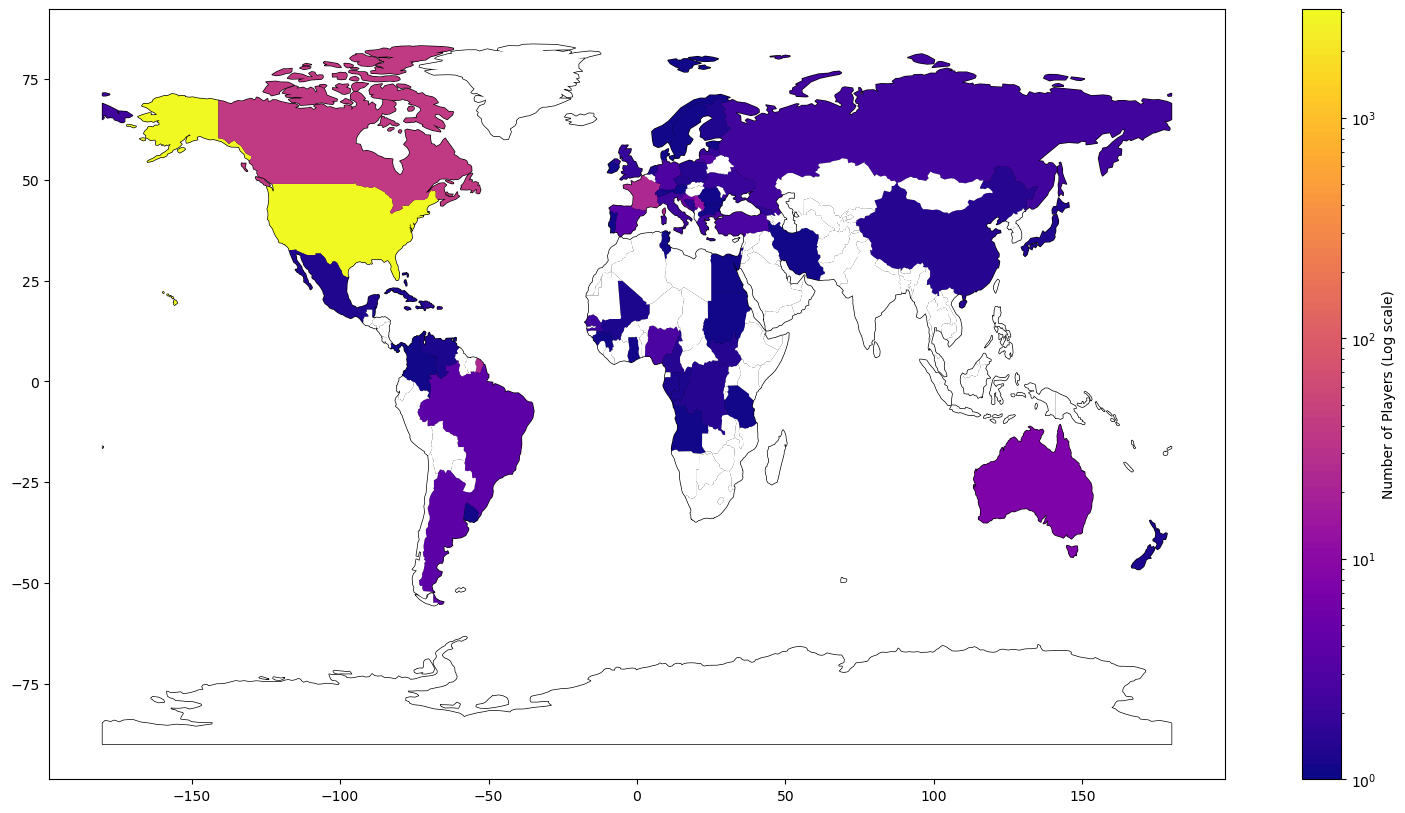

In [20]:
import geopandas
import matplotlib
from matplotlib.colors import LogNorm

# World map coloured by number of NBA players
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(20, 10), color="white", edgecolor="black")

cmap = matplotlib.colormaps["plasma"].resampled(100)

countries = {
    'Bosnia and Herzegovina': 'Bosnia and Herz.', 'Czech Republic': 'Czechia', 'DRC': 'Dem. Rep. Congo', 'Democratic Republic of the Congo': 'Dem. Rep. Congo',
    'Dominican Republic': 'Dominican Rep.', 'Macedonia': 'North Macedonia', 'Scotland': 'United Kingdom', 'South Sudan': 'S. Sudan',
    'USA': 'United States of America'
}

country_counts = common_player_df['country'].replace(countries).value_counts().to_dict()
min_count = min(country_counts.values())
max_count = max(country_counts.values())
norm = LogNorm(vmin=min_count, vmax=max_count)

for c in country_counts:
    c_rate = country_counts[c]
    if c not in world.name.values:
        continue
    world[world.name == c].plot(color=cmap(c_rate),ax=ax)
for c in world.name.values:
    if c not in country_counts:
        world[world.name == c].plot(color="white",ax=ax)
# norm=matplotlib.colors.Normalize(min_count, max_count)
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, label="Number of Players (Log scale)")
plt.show()